# Hebrew Study Notebook

In [22]:
import os, json
from pprint import pprint
import collections
from datetime import datetime
from IPython.display import display
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from iMahir import Study

In [2]:
home_dir = os.path.expanduser('~/')
hebrew = os.path.join(home_dir, 'Documents/vocabulary/hebrew.json')

In [3]:
heb = Study(hebrew)

preparing TF...
   |     0.00s No structure info in otext, the structure part of the T-API cannot be used


cycle for this set is complete...
keep cycle parameters the same?y
hebrew ready for study.
this is session 1:
score 4: 5 terms
score 3: 209 terms
score 2: 18 terms
score 1: 23 terms
score 0: 100 terms
total: 355


In [4]:
heb.learn()

The following scores were changed 
2<-3 		 3
0<-1 		 1
1->2 		 12
1<-2 		 3
2->3 		 11
0->1 		 7
0->2 		 4
0->3 		 3

duration:  1:32:35.852509

seconds per term: 15.65


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Notes

* fix צִיר (three different lexemes)
* merge עבות with עבת

## Study Stats

### Size of Known Term Set (Scores 3-4)

In [5]:
# get all sessions and session data
sessions = [sd for sd in heb.set_data['stats'] if 'score_counts' in sd]
score_lengths = [s['score_counts']['3']+s['score_counts']['4'] for s in sessions]
dates = [datetime.strptime(sd['date'], '%Y-%m-%d %H:%M:%S.%f') for sd in sessions]
date_labels = [datetime.strftime(time, format='%d-%m_%H:%M') for time in dates]
date2nlearned = dict(zip(date_labels, score_lengths)) # get dict for references

# plot this data only with cutoff
cutoff = -30 # max amount
plt_sessions = sessions[cutoff:]
plt_scores = score_lengths[cutoff:]
plt_dates = date_labels[cutoff:]

# calculate cycle lines
cycle_bounds = []
last_cycle = None
for i, sd in enumerate(plt_sessions):
    cycle = sd['cycle']
    last_cycle = cycle if not last_cycle else last_cycle
    if last_cycle != cycle:
        cycle_bounds.append(i-0.5)
        last_cycle = cycle

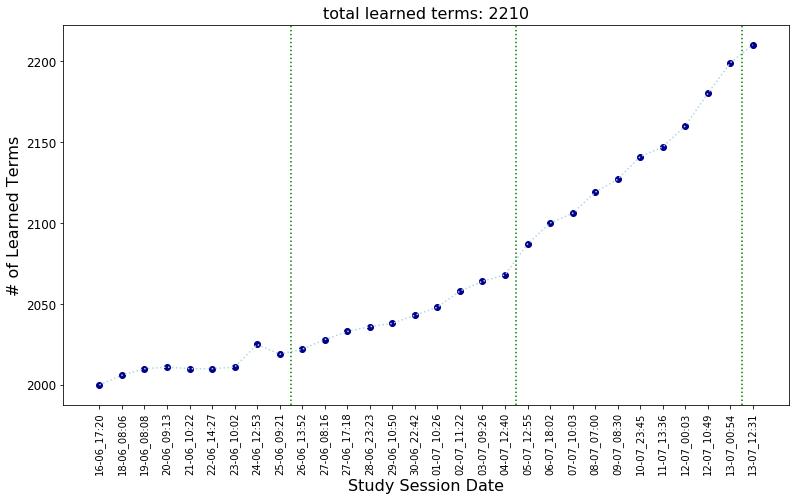

In [10]:
# make the plot
x = np.arange(len(plt_scores))
plt.figure(figsize=(13, 7))
plt.plot(x, plt_scores, linestyle='dotted', color='lightblue')
plt.scatter(x, plt_scores, color='darkblue')
plt.xticks(x, plt_dates, rotation=90, size=10)
plt.yticks(size=12)
plt.ylabel('# of Learned Terms', size=16)
plt.xlabel('Study Session Date', size=16)
plt.title(f'total learned terms: {plt_scores[-1]}', size=16)
for bound in cycle_bounds:
    plt.axvline(bound, color='green', linestyle='dotted')
plt.show()

In [12]:
print('n-learned since last cycle:', plt_scores[-1] - date2nlearned['13-07_00:54'])

n-learned since last cycle: 11


### Unlearned Terms by Frequency

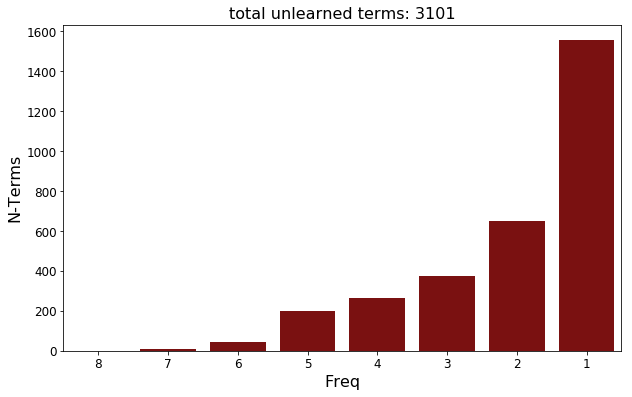

,0
8,1
7,9
6,45
5,198
4,265
3,376
2,652
1,1555


In [13]:
# get terms left to learn
to_learn = collections.Counter()
for i in heb.set_data['term_queues']['0']:
    term_lexs = heb.set_data['terms_dict'][i]['source_lexemes']
    for term in term_lexs:
        freq = heb.F.freq_lex.v(term)
        to_learn[freq] += 1           
to_learn = pd.DataFrame.from_dict(to_learn, orient='index').sort_values(by=0)

# make the plot
nbars = np.arange(to_learn.shape[0])
plt.figure(figsize=(10, 6))
sns.barplot(nbars, to_learn[0], color='darkred')
plt.xticks(nbars, labels=list(str(i) for i in to_learn.index), size=12)
plt.yticks(size=12)
plt.ylabel('N-Terms', size=16)
plt.xlabel('Freq', size=16)
plt.title(f'total unlearned terms: {to_learn[0].sum()}', size=16)
plt.show()
display(to_learn)

## Goals


### Learn them all
I want to knock out the remaining unlearned terms within the next year.

In [13]:
year = 365 # days
cycle_size = 10
total_unlearned = to_learn.sum()[0]

# based on previous cycle, calculate the quota 2 learned ratio
zero_quota = 50
learnedincycle = session2nlearned['04-07'] - session2nlearned['26-06'] # how many I've done in a cycle with 50
quota2learned = zero_quota / learnedincycle
learned2quota = learnedincycle / zero_quota
print(f'The quota-to-learned ratio is: {quota2learned}')
print(f'The learned-to-quota ratio is: {learned2quota}')

The quota-to-learned ratio is: 1.0869565217391304
The learned-to-quota ratio is: 0.92


So 92% of terms in the zero quota were learned in this cycle period.

Let's see what's needed to knock out the remaining unlearned terms in a year.

In [14]:
(total_unlearned * quota2learned / year) * cycle_size

98.12388326384752

Thus, I need 98 terms per cycle.

### Future

Determine the best cycle length in the future when all terms are scores 3-4

In [26]:
known_scores = plt_scores[-1]
total = known_scores + total_unlearned

total / 15 # cycle length of 15

357.53333333333336

In [27]:
total / 20 # cycle length 

268.15

In [29]:
total / 30 # cycle length

178.76666666666668